In [1]:
import activation_func as fn
from model import Model
from layer import Layer
from loss_func import MSE
from data_loader import DataLoader

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Dataset initialisation

In [3]:
def bytes_to_pixels(image):
    image_bytes = image
    image_array = np.frombuffer(image_bytes, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
    pixel_values = image.flatten()
    return pixel_values

In [4]:
training_data_path = 'dataset/train.parquet'
test_data_path = 'dataset/test.parquet'

In [5]:
percentage_of_dataset = 1

In [6]:
df1 = pd.read_parquet(training_data_path).rename(columns={'image.bytes': 'image'})
df2 = pd.read_parquet(test_data_path).rename(columns={'image.bytes': 'image'})

print(df1)

       label                                              image image.path
0          5  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
1          0  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
2          4  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
3          1  b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
4          9  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
...      ...                                                ...        ...
59995      8  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
59996      3  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
59997      5  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
59998      6  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None
59999      8  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...       None

[60000 rows x 3 columns]


In [7]:
df1['pixels'] = df1['image'].apply(bytes_to_pixels)

df2['pixels'] = df2['image'].apply(bytes_to_pixels)

df = pd.concat([df1[: int(len(df1) * percentage_of_dataset)], df2[: int(len(df2) * percentage_of_dataset)]], ignore_index=True)


print(df[['pixels', 'label']])

                                                  pixels  label
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      5
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      0
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      4
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      1
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      9
...                                                  ...    ...
69995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      2
69996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      3
69997  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      4
69998  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      5
69999  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      6

[70000 rows x 2 columns]


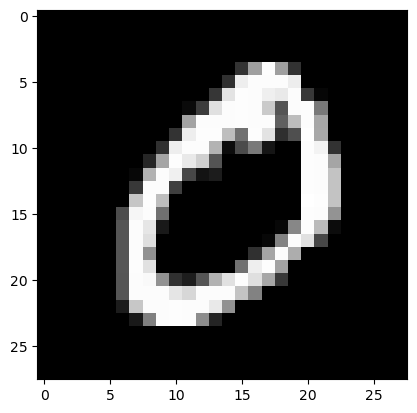

In [8]:
def draw_from_pixels(img):
    first_image_pixels = img
    image_shape = (28, 28)  

    image_array = np.array(first_image_pixels).reshape(image_shape)

    plt.imshow(image_array, cmap='gray')
    plt.show()

draw_from_pixels(df.loc[1, 'pixels'])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder


X = df[['pixels', 'label']].copy()

y = (X.pop('label')).astype(int).values.reshape(-1, 1)

X = np.vstack(df['pixels'].values)

train_valid_size = 0.14

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y_train
)


label_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

X_train.shape, y_train.shape

/home/andrzej/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((51771, 784), (51771, 10))

# Discriminator training

In [10]:
discriminator = Model()

discriminator.add_layer(Layer(in_features=28*28, out_features=256, activation_function=fn.ReLU(), batch_norm_1d_size=128))
discriminator.add_layer(Layer(in_features=256, out_features=128, activation_function=fn.ReLU(), batch_norm_1d_size=128))
discriminator.add_layer(Layer(in_features=128, out_features=10, activation_function=fn.Softmax()))

In [11]:
train_loader = DataLoader(X_train, y_train, size=256)

In [12]:
learning_rate = 1e-3
input_size = X_train.shape[1]
clear_output = y_train.shape[1]

num_epochs = 100

early_stopping_patience = 5

In [13]:
from copy import deepcopy

In [14]:
discriminator.set_learning_rate(learning_rate)

In [15]:
discriminator.train()

best_model = deepcopy(discriminator)
best_result = 10**10
no_proggress_counter = 0

for epoch in range(num_epochs):
    X_batch, y_batch = train_loader.get_batch()
    for i in range(len(X_batch)):
        y_pred = discriminator.forward(X_batch[i])
        discriminator.backward(y_batch[i])

    y_pred = discriminator.predict(X_train)
    loss = MSE(y_pred, y_train)

    no_proggress_counter += 1
    if loss < best_result:
        best_model = deepcopy(discriminator)
        best_result = loss
        no_proggress_counter = 0

    if epoch % 1 == 0:
        print(f"{epoch}: loss={loss}; best loss={best_result}")

    if no_proggress_counter == early_stopping_patience:
        print("Early stop")
        print(f"{epoch}: {best_result}")
        break


0: loss=0.0746011327294385; best loss=0.0746011327294385
1: loss=0.05130269798833649; best loss=0.05130269798833649
2: loss=0.04417144718117187; best loss=0.04417144718117187
3: loss=0.052334358243592415; best loss=0.04417144718117187
4: loss=0.041726084432913195; best loss=0.041726084432913195
5: loss=0.0388750458737528; best loss=0.0388750458737528
6: loss=0.03962450020281625; best loss=0.0388750458737528
7: loss=0.029671065644458094; best loss=0.029671065644458094
8: loss=0.03296053579065045; best loss=0.029671065644458094
9: loss=0.02512216841630102; best loss=0.02512216841630102
10: loss=0.032233968308236986; best loss=0.02512216841630102
11: loss=0.03066581677000636; best loss=0.02512216841630102
12: loss=0.02381642232136322; best loss=0.02381642232136322
13: loss=0.03232697832639758; best loss=0.02381642232136322
14: loss=0.0278724751786407; best loss=0.02381642232136322
15: loss=0.025539394641787873; best loss=0.02381642232136322
16: loss=0.025442817130266197; best loss=0.02381

## Testing

In [16]:
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


y_pred_test_score = best_model.predict(X_test)

auroc = roc_auc_score(y_test, y_pred_test_score)


y_true_flat = np.argmax(y_test, axis=1)
y_pred_flat = np.argmax(y_pred_test_score, axis=1)

accuracy = accuracy_score(y_true_flat, y_pred_flat)
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
classification_rep = classification_report(y_true_flat, y_pred_flat)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print(f"AUROC: {100 * auroc:.2f}%")

Accuracy: 0.8799102132435466
Confusion Matrix:
[[ 885    0   10   10    5    3   13    1   38    1]
 [   0 1063    8    1    0    1    9    3   18    0]
 [   2    2  864   18   20    0   14   16   39    4]
 [   2    4   18  870    0   17    9   18   57    5]
 [   1    0    7    0  826    0   13    8   16   84]
 [  24    4    6   67   11  592   30    9  125   16]
 [   7    4   19    1    6    9  897    0   19    1]
 [   1    7   22    2   14    0    0  957    4   14]
 [   5   19   25   21    3   11    6   24  837    5]
 [   8    7    6   11   29    7    0   46   27  833]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       966
           1       0.96      0.96      0.96      1103
           2       0.88      0.88      0.88       979
           3       0.87      0.87      0.87      1000
           4       0.90      0.86      0.88       955
           5       0.93      0.67      0.78       884
           6       0

In [17]:
path = 'models/discriminator1.pickle'
best_model.save(path)

# Generator

In [18]:
generator = Model(learning_rate=0.0001)

generator.add_layer(Layer(in_features=100, out_features=7*7, activation_function=fn.LeakyReLU(0.2)))
generator.add_layer(Layer(in_features=7*7, out_features=14*14, activation_function=fn.LeakyReLU(0.2)))
generator.add_layer(Layer(in_features=14*14, out_features=28*28, activation_function=fn.LeakyReLU(0.2)))

In [19]:
class GenTrainer:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator

        self.generator.train()
        self.discriminator.eval()

    def train(self, x, y):
        x = generator.forward(x)
        
        x = discriminator.forward(x)

        error = discriminator.backward(y)
        generator.backward(error)


In [20]:
prompt = 2

In [21]:
trainer = GenTrainer(generator, best_model)

In [22]:
one_hot_prompt = np.zeros(10)
one_hot_prompt[prompt] = 1

In [23]:
num_epochs = 200

In [24]:
for epoch in range(num_epochs):
    z = np.random.uniform(0, 255, 100)

    trainer.train(z, one_hot_prompt)

/home/andrzej/Documents/Informatyka/python/network-2.0/layer.py:43: RuntimeWarning: overflow encountered in matmul
  self.input = self.input_links @ self.weights
/home/andrzej/Documents/Informatyka/python/network-2.0/layer.py:43: RuntimeWarning: invalid value encountered in matmul
  self.input = self.input_links @ self.weights


In [25]:
z = np.random.uniform(0, 255, 100)
y = generator.predict(np.array([z]))

In [26]:
print(y)

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan 

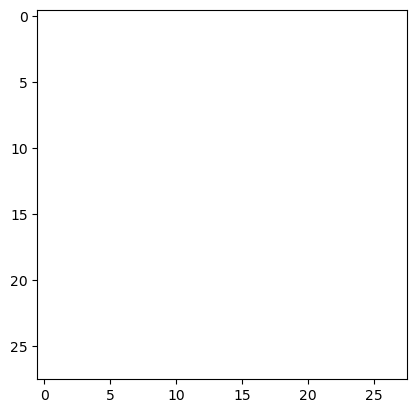

In [27]:
draw_from_pixels(y)